In [6]:
import bz2
import copy
import json
import matplotlib.pyplot as plt
import numpy as np
# %matplotlib qt

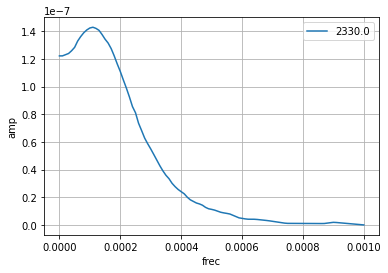

In [7]:
filename = "../protodune-noise-spectra-v1.json.bz2"
filename = "../microboone-noise-spectra-v1.json.bz2"
wire_specs = json.loads(bz2.BZ2File(filename, 'r').read())

def plot_wire_specs(wire_specs, planes=None):
    plt.figure()

    for i, wire_spec in enumerate(wire_specs) :
        if planes is not None and wire_spec['plane'] not in planes:
            continue
        plt.plot(wire_spec['freqs'],wire_spec['amps'],label=wire_spec['wirelen'])

    fontsize=10
    plt.legend(loc='best', fontsize=10)
    plt.grid()
    plt.xlabel("frec", fontsize=fontsize)
    plt.ylabel("amp", fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.show()

plot_wire_specs(wire_specs,[2])

In [8]:
# capacitance pF/m
capacitance_unit_pcb = [88, 88, 97] # (0,90), second number is a dummy
capacitance_unit_pcb = [109, 83, 91] # (0, -48, 90)
capacitance_unit_pcb = [100, 100, 79] # (30,-30,90)
capacitance_unit_microboone = 18
capacitance_unit_protodune  = 22

capacitance_base_microboone = 40 # pF
capacitance_base_protodune  = 40 # pF
capacitance_base_pdb        = 40 # pF

def wire_to_cap(wire_specs, unit_capacitance, base_capacitance) :
    output = copy.deepcopy(wire_specs)
    for i, wire_spec in enumerate(output) :
        wire_spec['wirelen'] = wire_spec['wirelen']/1000.*unit_capacitance + base_capacitance
    return output

def cap_to_wire(wire_specs, unit_capacitance, base_capacitance) :
    output = copy.deepcopy(wire_specs)
    for i, wire_spec in enumerate(output) :
        wire_spec['wirelen'] = (wire_spec['wirelen'] - base_capacitance)/unit_capacitance*1000.
    return output

def extend_len(input1, input2, target_length) :
    print('extend_len', input1['wirelen'], input2['wirelen'], target_length)
    output = copy.deepcopy(input1)
    len_t1 = target_length - input1['wirelen']
    len_21 = input2['wirelen'] - input1['wirelen']
    if(len_21 == 0) :
        raise Exception('len_21 == 0')
    amps_o = np.asarray(output['amps'])
    amps_1 = np.asarray(input1['amps'])
    amps_2 = np.asarray(input2['amps'])
    if(len(amps_2)!=len(amps_1)) :
        raise Exception('len(amps_2)!=len(amps_1)')
    amps_o = amps_o + len_t1/len_21*(amps_2-amps_1)
    output['wirelen'] = target_length
    output['amps'] = amps_o.tolist()
    return output

def update_plane_info(wire_specs, nsamples, plane) :
    for i, wire_spec in enumerate(wire_specs) :
        wire_spec['nsamples'] = nsamples
        wire_spec['plane'] = plane

# wire_specs_microboone[0]

extend_len 43.528 205.0 300


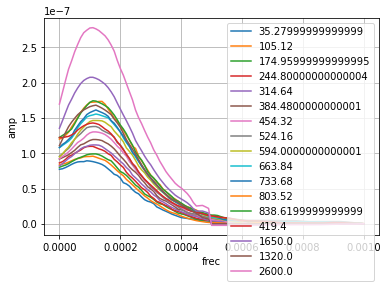

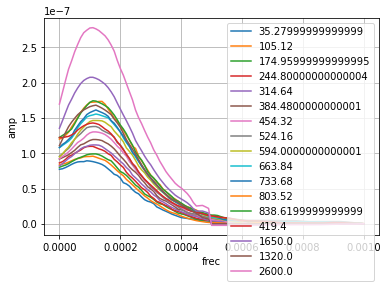

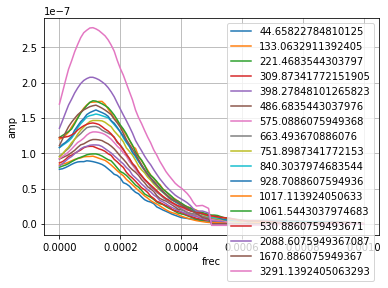

In [9]:
wire_specs_microboone = json.loads(bz2.BZ2File("../microboone-noise-spectra-v1.json.bz2", 'r').read())
wire_specs_protodune  = json.loads(bz2.BZ2File("../protodune-noise-spectra-v1.json.bz2", 'r').read())

# only use plane U and W and remove dups for pdune
wire_specs_microboone = [x for x in wire_specs_microboone if x['plane'] == 0 or x['plane'] == 2]
wire_specs_protodune = [x for x in wire_specs_protodune 
                        if (x['plane'] == 0 and x['wirelen'] == 7500) 
                        or (x['plane'] == 2 and x['wirelen'] == 6000) ]

wire_specs_cap_microboone = wire_to_cap(wire_specs_microboone, capacitance_unit_microboone, capacitance_base_microboone)
wire_specs_cap_protodune = wire_to_cap(wire_specs_protodune, capacitance_unit_protodune, capacitance_base_protodune)
wire_specs_cap = wire_specs_cap_microboone + wire_specs_cap_protodune
wire_specs_cap.append(extend_len(wire_specs_cap[0], wire_specs_cap[-2], 300))
wire_specs_pcb = []
for plane, capacitance_unit in enumerate(capacitance_unit_pcb) :
    tmp = cap_to_wire(wire_specs_cap, capacitance_unit, capacitance_base_pdb)
    update_plane_info(tmp, nsamples=6000, plane=plane)
    wire_specs_pcb = wire_specs_pcb + tmp

btext = json.dumps(wire_specs_pcb, indent=2).encode()
bz2.BZ2File("dunevd10kt_3view_30deg_noise_spectra_v1.json.bz2", 'w').write(btext)

plot_wire_specs(wire_specs_pcb[0:17])
plot_wire_specs(wire_specs_pcb[17:34])
plot_wire_specs(wire_specs_pcb[34:])

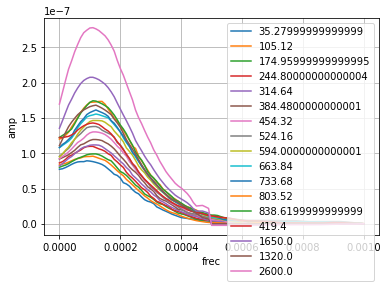

In [10]:
test = json.loads(bz2.BZ2File("dunevd10kt_3view_30deg_noise_spectra_v1.json.bz2", 'r').read())
plot_wire_specs(test[0:17])